# Conceitos de underfitting, overfitting e regularização

Esse tutorial visa explicar os conceitos de *underfitting*, *overfitting* e regularização através de um exemplo de ajuste de curva usando o keras.

*Underfitting* ocorre quando o modelo não é capaz de representar a natureza dos dados. Normalmente resolve-se o *underfitting* aumentando a complexidade do modelo de ajuste; em redes neurais, isso é equivalente a aumentar o número de camadas e o número de neurônios por camada.

*Overfitting* ocorre quando o modelo se adequa excessivamente aos dados de entrada, de forma que ele se torna específico demais para os dados de treinamento e torna-se incapaz de generalizar para novos dados.

Regularização é uma técnica para evitar o *overfitting*.

O tutorial é uma adaptação do exemplo apresentado no capítulo 1 do livro:
"Christopher M. Bishop. 2006. Pattern Recognition and Machine Learning (Information Science and Statistics). Springer-Verlag New York, Inc., Secaucus, NJ, USA."

# Função de custo com regularização L2

$$\Large E(\boldsymbol{w})=\frac{1}{2}\sum_{n=1}^N\{\hat{y}(x_n,\boldsymbol{w})-y_n\}^2 +\frac{\lambda}{2}||\boldsymbol{W}||^2$$

# Importação das bibliotecas - NumPy, matplotlib e ipywidgets

In [1]:
%matplotlib notebook
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

# Funções para exibição dos resultados e realização dos treinamentos

In [83]:
FIGSIZE = (8, 4)
DPI = 100
PATIENCE = 10000
CUDA = False

d_loss = dict()

def show_model_results(fig, x_orig, y_orig, x_train, y_train, x_test, y_test, loss=None, y_predict=None, n_epochs=None):
    x_orig = x_orig.data.cpu().numpy().reshape(-1,)
    y_orig = y_orig.data.cpu().numpy().reshape(-1,)
    x_train = x_train.data.cpu().numpy().reshape(-1,)
    y_train = y_train.data.cpu().numpy().reshape(-1,)
    x_test = x_test.data.cpu().numpy().reshape(-1,)
    y_test = y_test.data.cpu().numpy().reshape(-1,)
    if y_predict is not None:
        y_predict = y_predict.data.cpu().numpy().reshape(-1,)
    loss = loss.data[0]

    # Gráfico do sinal sem ruído, dos conjuntos de treinamento e de teste, e o ajuste
    plt.cla()
    ax1 = fig.add_subplot(1, 1, 1)
    title = ''
    if n_epochs is not None:
        title += 'Epochs: {}   '.format(n_epochs)
    if loss is not None:
        title += 'Loss: {:.4f}'.format(loss)
    if len(title) != 0:
        ax1.set_title(title)
    ax1.plot(x_orig, y_orig, linewidth=2.0, label=r'Modelo: $sin(2 \pi x)$')
    if y_predict is not None:
        ax1.plot(x_train, y_predict, linewidth=2.0, label='Ajuste')
    ax1.plot(x_test, y_test, 'x', color='black', label = "Teste")
    ax1.plot(x_train, y_train, 'o', color='red', label = "Treinamento")
    ax1.legend()
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    fig.canvas.draw()

def get_model(n_hidden_neurons=0):
    n_hidden_neurons = int(n_hidden_neurons)
    if n_hidden_neurons < 0:
        raise ValueError('n_hidden_neurons must be zero or positive')
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            if n_hidden_neurons == 0:
                self.linr01 = nn.Linear(in_features=1, out_features=1)
            else:
                self.linr01 = nn.Linear(in_features=1, out_features=n_hidden_neurons)
                self.linr02 = nn.Linear(in_features=n_hidden_neurons, out_features=1)
        def forward(self, x):
            if n_hidden_neurons == 0:
                x = self.linr01(x)
            else:
                x = F.sigmoid(self.linr01(x))
                x = self.linr02(x)
            return x
    net = Net()
    if torch.cuda.is_available() and CUDA:
        net.cuda()
    return net

def train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test):
    net.train()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.RMSprop(params=net.parameters(), lr=0.5e-2, weight_decay=reg_factor)
    i_epoch = 0
    i_best = 0
    loss_best = np.inf
    d_state_best = net.state_dict()
    train = True
    while train:
        try:
            y_predict = net(x_train)
            loss = criterion(y_predict, y_train)
            if loss.data[0] < loss_best:
                loss_best = loss.data[0]
                i_best = i_epoch
                d_state_best = net.state_dict()
            if PATIENCE < i_epoch - i_best:
                net.load_state_dict(d_state_best)
                net.eval()
                y_predict = net(x_train)
                show_model_results(fig, x_orig, y_orig, x_train, y_train, x_test, y_test, loss, y_predict, i_best)
                break
            if i_epoch % 2000 == 0:
                show_model_results(fig, x_orig, y_orig, x_train, y_train, x_test, y_test, loss, y_predict, i_epoch)
            i_epoch += 1
            loss.backward()
            optimizer.step()
        except KeyboardInterrupt:
            train = False
    print('Finished training.')

# Gerando dados sintéticos com ruído
São gerados 10 pontos de treinamento (representados pelos pontos marcados com círculos vermelhos no gráfico) e 100 pontos de teste (representados pelos pontos marcados com cruzes pretas). O objetivo é treinar usando os pontos vermelhos e testar usando os pontos pretos.

<IPython.core.display.Javascript object>


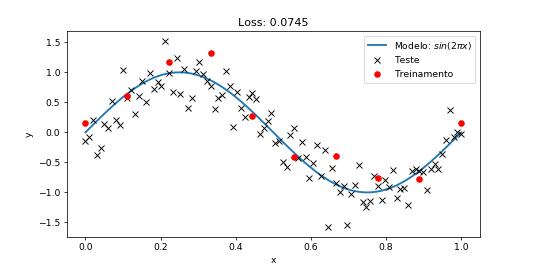

In [84]:
# Variância do ruído
var = 0.3
np.random.seed(42)

# Conjunto de treino
train_size = 10
x_train = np.linspace(0.0, 1.0, train_size)
y_train = np.sin(2.0 * np.pi * x_train) + np.random.normal(0.0, var, train_size) # sinal + ruido

# Conjunto de teste
test_size = 100
x_test = np.linspace(0.0, 1.0, test_size)
y = np.sin(2.0 * np.pi * x_test)
y_test = y + np.random.normal(0.0, var, test_size) # sinal + ruido

x_orig = x_test
y_orig = y

x_train = torch.from_numpy(x_train.reshape(-1, 1)).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train.reshape(-1, 1)).type(torch.FloatTensor)
x_test = torch.from_numpy(x_test.reshape(-1, 1)).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test.reshape(-1, 1)).type(torch.FloatTensor)
x_orig = torch.from_numpy(x_orig.reshape(-1, 1)).type(torch.FloatTensor)
y_orig = torch.from_numpy(y_orig.reshape(-1, 1)).type(torch.FloatTensor)

if torch.cuda.is_available() and CUDA:
    x_train = x_train.cuda()
    y_train = y_train.cuda()
    x_test = x_test.cuda()
    y_test = y_test.cuda()
    x_orig = x_orig.cuda()
    y_orig = y_orig.cuda()

x_train = Variable(x_train)
y_train = Variable(y_train)
x_test = Variable(x_test)
y_test = Variable(y_test)
x_orig = Variable(x_orig)
y_orig = Variable(y_orig)

criterion = torch.nn.MSELoss()
loss = criterion(y_orig, y_test)

# Gráfico do sinal sem ruído, e dos conjuntos de treinamento e de teste
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
show_model_results(fig, x_orig, y_orig, x_train, y_train, x_test, y_test, loss)

<IPython.core.display.Javascript object>


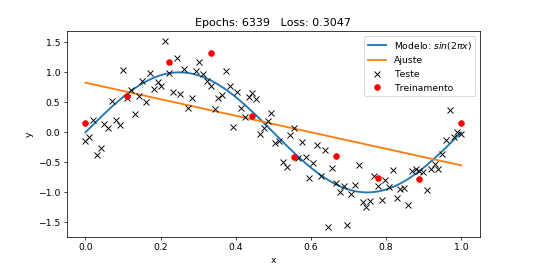

Finished training.


In [23]:
n_hidden_neurons = 0
reg_factor = 0.
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


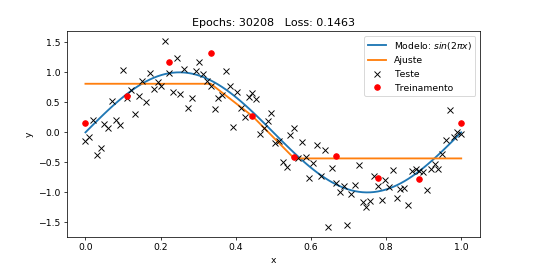

Finished training.


In [24]:
n_hidden_neurons = 1
reg_factor = 0.
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


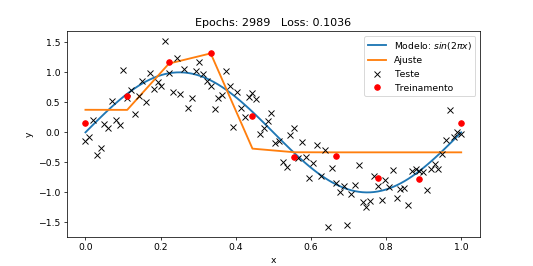

Finished training.


In [32]:
n_hidden_neurons = 2
reg_factor = 0.
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


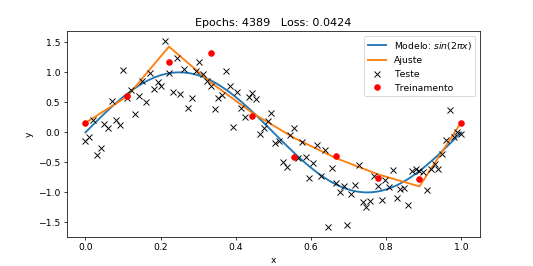

Finished training.


In [28]:
n_hidden_neurons = 4
reg_factor = 0.
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


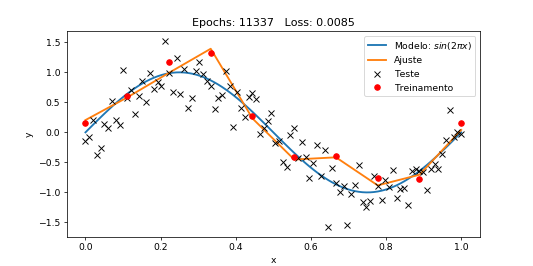

Finished training.


In [33]:
n_hidden_neurons = 8
reg_factor = 0.
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


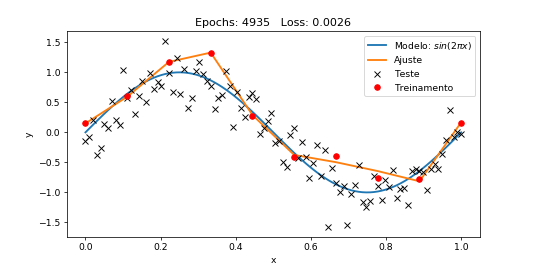

Finished training.


In [34]:
n_hidden_neurons = 16
reg_factor = 0.
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


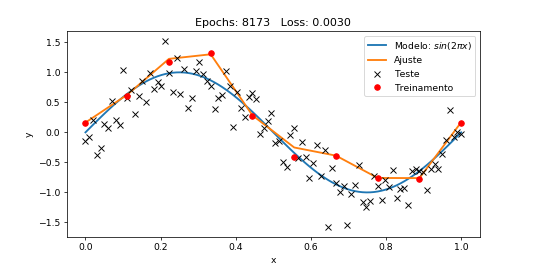

Finished training.


In [44]:
n_hidden_neurons = 16
reg_factor = 0.001
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


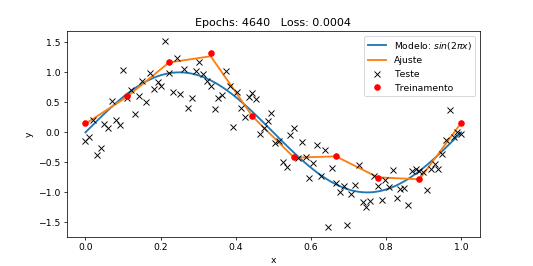

Finished training.


In [45]:
n_hidden_neurons = 16
reg_factor = 0.01
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


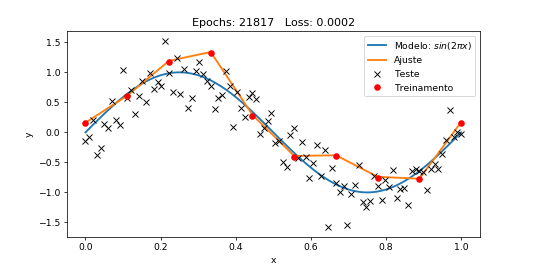

Finished training.


In [46]:
n_hidden_neurons = 16
reg_factor = 0.1
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


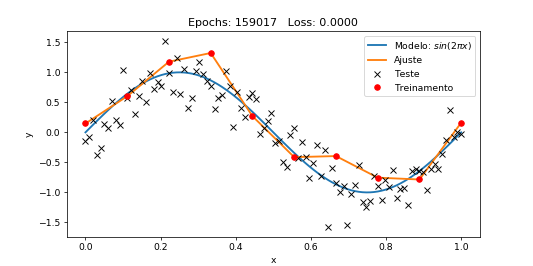

Finished training.


In [47]:
n_hidden_neurons = 16
reg_factor = 1.0
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


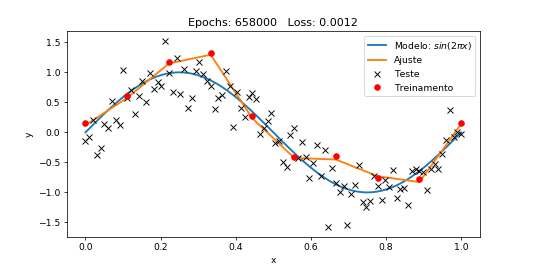

Finished training.


In [74]:
n_hidden_neurons = 16
reg_factor = 10.0
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


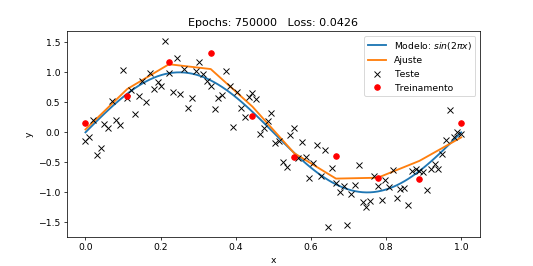

Finished training.


In [49]:
n_hidden_neurons = 16
reg_factor = 100.0
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


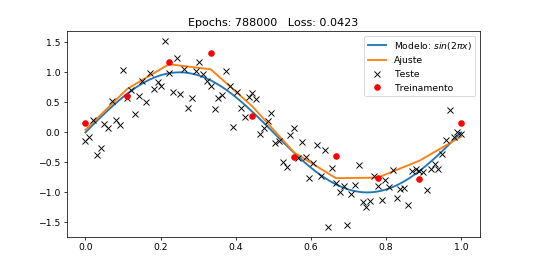

Finished training.


In [85]:
n_hidden_neurons = 16
reg_factor = 100.0
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


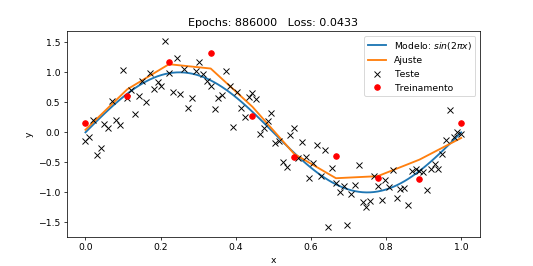

Finished training.


In [57]:
n_hidden_neurons = 16
reg_factor = 200.0
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


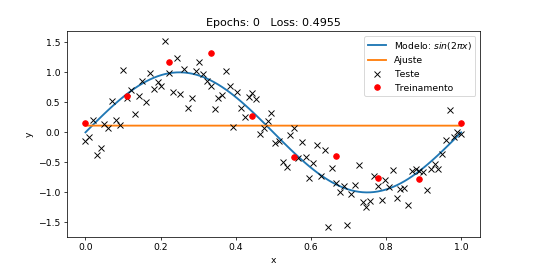

Finished training.


In [88]:
n_hidden_neurons = 16
reg_factor = 1000.0
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)